# Text and Sentiment Analysis

### Messages with Ella 2013 - 2020

High level and sentiment analysis of messages to date

### Importing key libraries

In [1]:
import numpy as np
import pandas as pd
import json
import datetime
import os
import emoji
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Importing data

In [3]:
directory = 'Ella'

df = pd.DataFrame()

# Go through folder containing all JSON files with conversation history with Ella
for filename in os.listdir(directory):
    if filename.endswith('.json'):
        f = open(directory + '/' + filename)
        data_segment = json.load(f)
        
        # Take message part of JSON string
        messages_segment = data_segment['messages']
        
        # Convert messages to data frame format
        df_segment = pd.DataFrame(messages_segment)
    
    # Concatenate together the different subsets of message history
    # Will create data frame with column for any unique column
    df = pd.concat([df,df_segment], axis = 0, sort = False)


# Due to issues with Facebook JSON export, messages often duplicated; dropping those with same ms time stamp    
df.drop_duplicates(subset = 'timestamp_ms', inplace = True)

# Changing date time text field to pandas date time object
# Facebook uses ms, requires 1000x adjustment using datetime.datetime.fromtimestamp for conversion
df['timestamp_ms'] = df['timestamp_ms'].apply(lambda x: pd.to_datetime(datetime.datetime.fromtimestamp(x/1000)))

# Create one unified index on the new dataset
df.sort_values('timestamp_ms', ascending = False, inplace = True)
df.reset_index(inplace = True, drop = True)


### Preprocessing

In [4]:
# Decoding emoji
df['content'] = df['content'].apply(lambda x: str(x).encode('latin1').decode('utf8') if str(x) != 'nan' else '')

In [5]:
# Adding word count
df['word_count'] = df['content'].apply(lambda x: len(x.split()))

In [6]:
# Adding further time aggregation and mapping day of week to string values
df['hour'] = df['timestamp_ms'].apply(lambda x: x.hour)
df['day_of_week'] = df['timestamp_ms'].apply(lambda x: x.dayofweek)

df['day_of_week'] = df['day_of_week'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'})

In [7]:
# Adding categorical field to identify living together
df['living_together'] = df['timestamp_ms'].apply(lambda x: True if x > pd.to_datetime('2016-02-01') else False)

In [8]:
# Check total word count
print('Total words: ' + str(df['word_count'].sum()))

Total words: 688414


### Plotting Message Count Over Time

In [9]:
sns.set_style('whitegrid')
sns.set_palette('GnBu_d')

In [10]:
# Create data frames showing count of messages per day
daily_tom = df[df['sender_name'] == 'Tom Brash'].set_index('timestamp_ms').groupby(pd.Grouper(freq = 'D')).count()
daily_ella = df[df['sender_name'] == 'Ella Thompson'].set_index('timestamp_ms').groupby(pd.Grouper(freq = 'D')).count()

# Add rolling 1 month average to each data frame
daily_tom['rolling'] = daily_tom['sender_name'].rolling(window = 30).mean()
daily_ella['rolling'] = daily_ella['sender_name'].rolling(window = 30).mean()

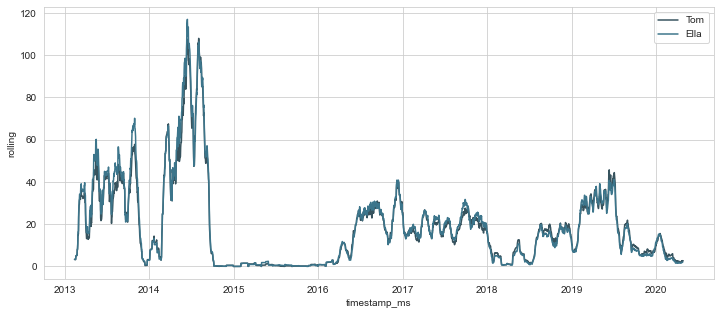

In [11]:
plt.figure(figsize = (12,5))

sns.lineplot(x = 'timestamp_ms', y ='rolling', data = daily_tom.reset_index(), label = 'Tom')
sns.lineplot(x = 'timestamp_ms', y ='rolling', data = daily_ella.reset_index(), label = 'Ella')

## Plotting Word Count Over Time

In [12]:
# Create data frames showing number of words per day
daily_tom_words = df[df['sender_name'] == 'Tom Brash'].set_index('timestamp_ms').groupby(pd.Grouper(freq = 'D')).sum()
daily_ella_words = df[df['sender_name'] == 'Ella Thompson'].set_index('timestamp_ms').groupby(pd.Grouper(freq = 'D')).sum()

# Add rolling 1 month average to each data frame 
daily_tom_words['rolling'] = daily_tom_words['word_count'].rolling(window = 30).mean()
daily_ella_words['rolling'] = daily_ella_words['word_count'].rolling(window = 30).mean()

In [13]:
sns.set_palette('husl')

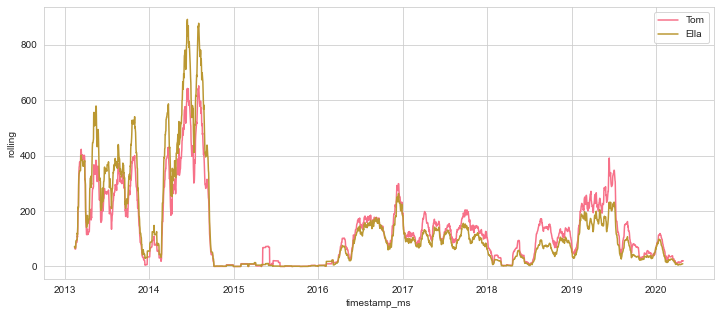

In [14]:
plt.figure(figsize = (12,5))

sns.lineplot(x = 'timestamp_ms', y = 'rolling', data = daily_tom_words.reset_index(), label = 'Tom')
sns.lineplot(x = 'timestamp_ms', y = 'rolling', data = daily_ella_words.reset_index(), label = 'Ella')

### Looking at Messages by Time of Day

In [15]:
df_times = pd.pivot_table(df, index = ['living_together', 'day_of_week'], columns = 'hour', aggfunc= 'sum')['word_count'].T

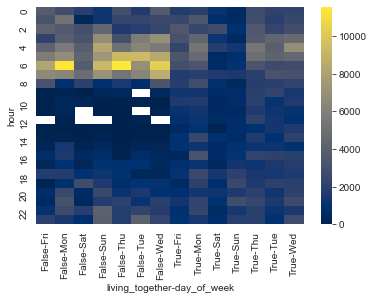

In [16]:
sns.heatmap(df_times, cmap = 'cividis')

## Textual Analysis

In [17]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
from nltk.collocations import *

import string

In [18]:
lemmatizer = WordNetLemmatizer()

In [19]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

# Removing some common words unique to Facebook's export
stopwords_list += ['called', 'theme', 'chat', 'attachment', 'missed', 'call', 'attachment.', 'ella.', 'tom.', 'theme', 'video', 'ended']

In [20]:
def lemmatized_corpus(name):

    # Repeatedly called set of instructions to take full body of a person's messages, split
    # into individual tokens, and lemmatize
    
    # Create corpus of messages
    corpus = ' '.join(df[df['sender_name'] == name]['content'])
    
    # Split corpus into individual words: note nltk tokenizer does not work well with string escapes
    tokens = corpus.lower().split()
    
    # Lemmatize tokens for further accuracy
    tokens_lem = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords_list]
    
    return tokens_lem

### Most common words

In [21]:
def top_words(name):
    
    tokens_lem = lemmatized_corpus(name)

    # Return top 20 words for the person in a neatly organized DataFrame
    top_words = pd.DataFrame(nltk.FreqDist(tokens_lem).most_common(20), columns = [name + '_word',name + '_freq'])
    return top_words   

In [22]:
freq_words = pd.concat([top_words('Tom Brash'), top_words('Ella Thompson')], axis = 1)

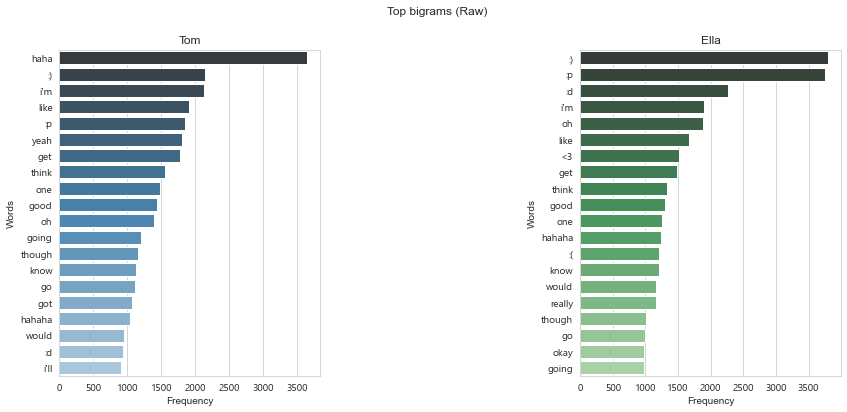

In [23]:
fig, ax = plt.subplots (1, 2, figsize = (14,6))
plt.subplots_adjust(wspace = 1)

sns.barplot(y = 'Tom Brash_word', x = 'Tom Brash_freq', data = freq_words, ax = ax[0], palette = 'Blues_d')
sns.barplot(y = 'Ella Thompson_word', x = 'Ella Thompson_freq', data = freq_words, ax = ax[1], palette = 'Greens_d')

plt.suptitle('Top bigrams (Raw)')

ax[0].title.set_text('Tom')
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Words')

for tick in ax[0].get_xticklabels():
    tick.set_fontname("Segoe UI Emoji")
for tick in ax[0].get_yticklabels():
    tick.set_fontname("Segoe UI Emoji")

ax[1].title.set_text('Ella')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Words')

for tick in ax[1].get_xticklabels():
    tick.set_fontname("Segoe UI Emoji")
for tick in ax[1].get_yticklabels():
    tick.set_fontname("Segoe UI Emoji")

### Most common bigrams

In [24]:
def top_bigrams(name):
    
    tokens_lem = lemmatized_corpus(name)
    
    bigram_finder = BigramCollocationFinder.from_words(tokens_lem)    
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    
    bi_scored = pd.DataFrame(bigram_finder.score_ngrams(bigram_measures.raw_freq), 
                             columns = [name + '_bigrams', name + '_freq'])
    
    return bi_scored
    
    

In [25]:
bigrams = pd.concat([top_bigrams('Tom Brash'), top_bigrams('Ella Thompson')], axis = 1).head(20)

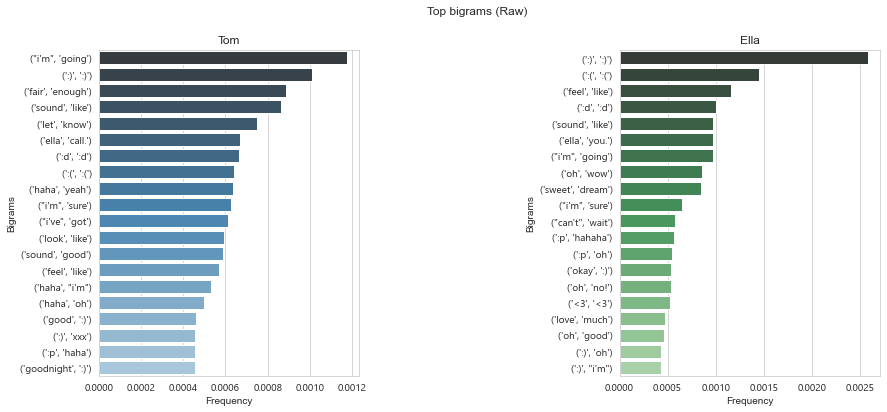

In [26]:
fig, ax = plt.subplots (1, 2, figsize = (14,6))
plt.subplots_adjust(wspace = 1)

sns.barplot(y = 'Tom Brash_bigrams', x = 'Tom Brash_freq', data = bigrams, ax = ax[0], palette = 'Blues_d')
sns.barplot(y = 'Ella Thompson_bigrams', x = 'Ella Thompson_freq', data = bigrams, ax = ax[1], palette = 'Greens_d')

plt.suptitle('Top bigrams (Raw)')

ax[0].title.set_text('Tom')
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Bigrams')

for tick in ax[0].get_xticklabels():
    tick.set_fontname("Segoe UI Emoji")
for tick in ax[0].get_yticklabels():
    tick.set_fontname("Segoe UI Emoji")

ax[1].title.set_text('Ella')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Bigrams')

for tick in ax[1].get_xticklabels():
    tick.set_fontname("Segoe UI Emoji")
for tick in ax[1].get_yticklabels():
    tick.set_fontname("Segoe UI Emoji")


In [27]:
def top_bigrams_pmi(name):
    
    tokens_lem = lemmatized_corpus(name)    
    bigram_finder = BigramCollocationFinder.from_words(tokens_lem)    
    bigram_finder.apply_freq_filter(30)    
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    pmi_score = pd.DataFrame(bigram_finder.score_ngrams(bigram_measures.pmi), columns = [name + '_bigrams', name + '_freq'])
    
    return pmi_score
    

In [28]:
bigrams_pmi = pd.concat([top_bigrams_pmi('Tom Brash'), top_bigrams_pmi('Ella Thompson')], axis = 1).head(20)

D:\Python\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 55357 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Python\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 56862 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Python\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 55357 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Python\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 56862 missing from current font.
  font.set_text(s, 0, flags=flags)


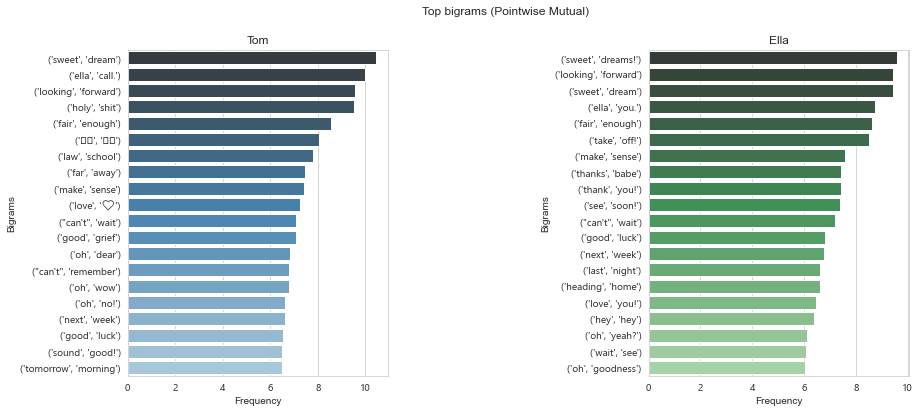

In [29]:
fig, ax = plt.subplots(1,2, figsize = (14,6))
plt.subplots_adjust(wspace = 1)

sns.barplot(y = 'Tom Brash_bigrams', x = 'Tom Brash_freq', data = bigrams_pmi, ax = ax[0], palette = 'Blues_d')
sns.barplot(y = 'Ella Thompson_bigrams', x = 'Ella Thompson_freq', data = bigrams_pmi, ax = ax[1], palette = 'Greens_d')

plt.suptitle('Top bigrams (Pointwise Mutual)')

ax[0].title.set_text('Tom')
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Bigrams')

for tick in ax[0].get_xticklabels():
    tick.set_fontname("Segoe UI Emoji")
for tick in ax[0].get_yticklabels():
    tick.set_fontname("Segoe UI Emoji")

ax[1].title.set_text('Ella')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Bigrams')

for tick in ax[1].get_xticklabels():
    tick.set_fontname("Segoe UI Emoji")
for tick in ax[1].get_yticklabels():
    tick.set_fontname("Segoe UI Emoji")



## Sentiment analysis

In [30]:
from nltk.sentiment import vader

In [31]:
analyzer = vader.SentimentIntensityAnalyzer()

Create replica of data set grouped by date, summarizing all messages from a single day into one `content` field. Then determine polarity scores for each daily message group

In [32]:
df_s = df

In [33]:
df_s['date'] = df_s['timestamp_ms'].apply(lambda x: x.date())

In [34]:
df_s = df_s.groupby(['date','sender_name'])[['content']].agg(lambda x: ' '.join(x)).reset_index()

In [35]:
df_s['sentiment'] = df_s['content'].apply(lambda x: analyzer.polarity_scores(x))

In [36]:
df_s['neg'] = df_s['sentiment'].apply(lambda x: x['neg'])
df_s['pos'] = df_s['sentiment'].apply(lambda x: x['pos'])
df_s['compound'] = df_s['sentiment'].apply(lambda x: x['compound'])

In [37]:
df_s['word_count'] = df_s['content'].apply(lambda x: len(x.split()))

In [38]:
df_s['year'] = df_s['date'].apply(lambda x: x.year)

In [39]:
df_s.drop('sentiment', axis = 1, inplace = True)

In [40]:
df_s_yearly_mean = df_s.groupby(['year','sender_name']).mean().reset_index()

### Graph of all days in sample by sentiment

(0.0, 0.6)

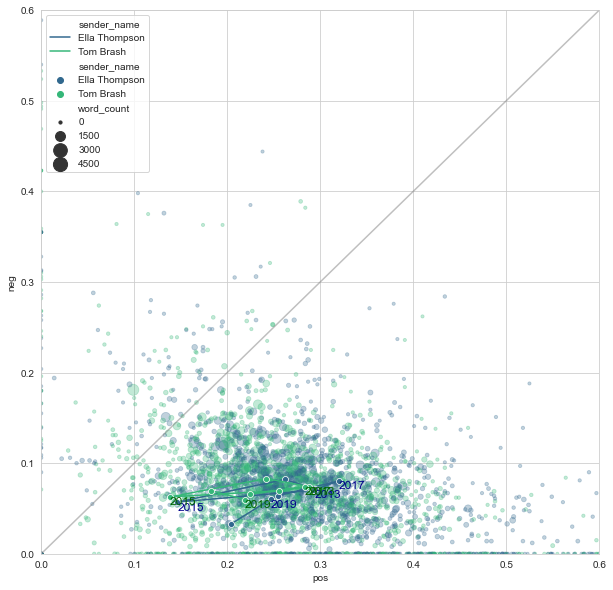

In [47]:
plt.figure(figsize = (10,10))

x = np.linspace(0,1,10)
y = x


sns.scatterplot(x = 'pos', y = 'neg', data = df_s, 
                hue = 'sender_name', size = 'word_count', 
                palette = 'viridis', edgecolor = None, alpha = 0.3, sizes = (10,200))

sns.lineplot(x = x, y = y, color = 'grey', alpha = 0.5)



plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))


sns.lineplot(x = 'pos', y = 'neg', hue = 'sender_name', data = df_s_yearly_mean, sort = False, 
             marker = 'o', palette = 'viridis')


for line in range(0, df_s_yearly_mean.shape[0]//4):
    plt.text(df_s_yearly_mean['pos'][line*4], df_s_yearly_mean['neg'][line*4], df_s_yearly_mean['year'][line*4],
             horizontalalignment = 'left', verticalalignment = 'top', size = 'large', color = 'darkblue')
        
    plt.text(df_s_yearly_mean['pos'][line*4+1], df_s_yearly_mean['neg'][line*4+1], df_s_yearly_mean['year'][line*4+1],
             horizontalalignment = 'left', verticalalignment = 'top', size = 'large', color = 'darkgreen')
    
    
plt.ylim(0,0.6)
plt.xlim(0,0.6)

### Graph of average positive and negative messenger sentiment over yearly period

(0.0, 0.38417964071856253)

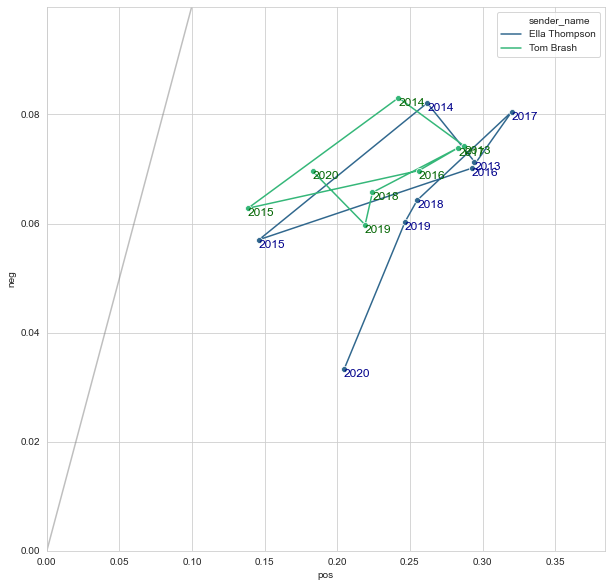

In [46]:
plt.figure(figsize = (10,10))

sns.lineplot(x = 'pos', y = 'neg', hue = 'sender_name', data = df_s_yearly_mean, sort = False, 
             marker = 'o', palette = 'viridis')


for line in range(0, df_s_yearly_mean.shape[0]//2):
    plt.text(df_s_yearly_mean['pos'][line*2], df_s_yearly_mean['neg'][line*2], df_s_yearly_mean['year'][line*2],
             horizontalalignment = 'left', verticalalignment = 'top', size = 'large', color = 'darkblue')
        
    plt.text(df_s_yearly_mean['pos'][line*2+1], df_s_yearly_mean['neg'][line*2+1], df_s_yearly_mean['year'][line*2+1],
             horizontalalignment = 'left', verticalalignment = 'top', size = 'large', color = 'darkgreen')

x = np.linspace(0,1,10)
y = x

sns.lineplot(x = x, y = y, color = 'grey', alpha = 0.5)

plt.ylim(0,df_s_yearly_mean['neg'].max()*1.2)
plt.xlim(0,df_s_yearly_mean['pos'].max()*1.2)


### Highlights of messages at either end of spectrum

In [43]:
df_s[df_s['neg'] == 1]

,date,sender_name,content,neg,pos,compound,word_count,year
2490,2018-12-27,Tom Brash,No,1.0,0.0,-0.296,1,2018


In [44]:
df_s[df_s['neg'] >0.5]

,date,sender_name,content,neg,pos,compound,word_count,year
197,2013-06-26,Ella Thompson,A murder on stage?!,0.714,0.0,-0.7177,4,2013
206,2013-07-04,Ella Thompson,The movie wasn't very good :D,0.603,0.0,-0.7247,6,2013
431,2013-12-25,Tom Brash,No new snoopy,0.524,0.0,-0.2960,3,2013
553,2014-04-23,Ella Thompson,638 6397 Call my home phone? My battery is dea...,0.589,0.0,-0.9660,23,2014
833,2015-05-26,Ella Thompson,Dunedin :(,0.744,0.0,-0.4404,2,2015
1508,2017-03-11,Ella Thompson,No no I should be home soon!,0.540,0.0,-0.5707,7,2017
2040,2017-12-23,Ella Thompson,Oh no!!,0.736,0.0,-0.4184,2,2017
2041,2017-12-23,Tom Brash,Sad :( Mum got a chrome cast! OH NO,0.649,0.0,-0.8491,9,2017
2490,2018-12-27,Tom Brash,No,1.000,0.0,-0.2960,1,2018
3233,2020-03-10,Tom Brash,Dude this sucks What an idiot fuck me,0.650,0.0,-0.8519,8,2020
